<a href="https://colab.research.google.com/github/YejinS/SimCLR_prostateSet_eval/blob/main/SimCLR_prostateSet_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import sys
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import torchvision

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def get_file_id_by_model(folder_name):
  file_id = {'resnet18_100-epochs_stl10': '14_nH2FkyKbt61cieQDiSbBVNP8-gtwgF',
             'resnet18_100-epochs_cifar10': '1lc2aoVtrAetGn0PnTkOyFzPCIucOJq7C',
             'resnet50_50-epochs_stl10': '1ByTKAUsdm_X7tLcii6oAEl5qFRqRMZSu'}
  return file_id.get(folder_name, "Model not found.")

In [ ]:
folder_name = 'resnet18_100-epochs_stl10'
file_id = get_file_id_by_model(folder_name)
print(folder_name, file_id)

resnet18_100-epochs_stl10 14_nH2FkyKbt61cieQDiSbBVNP8-gtwgF


In [ ]:
# download and extract model files
os.system('gdown https://drive.google.com/uc?id={}'.format(file_id))
os.system('unzip {}'.format(folder_name))
!ls

checkpoint_0100.pth.tar
config.yml
drive
events.out.tfevents.1610901470.4cb2c837708d.2683858.0
resnet18_100-epochs_stl10.zip
runs
sample_data
training.log


In [ ]:
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.transforms as transforms
from torchvision import datasets

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


## Custom Dataset (Prostate Dataset) 정의 & 불러오기

In [ ]:
#Prostate Dataset 클래스 정의

import pandas as pd
from skimage import io
import cv2
from PIL import Image

class prostate_dataset(Dataset):
    def __init__(self, csv_file, root, download, split, transform=None):
        self.train_image = pd.read_csv(csv_file)
        self.valid_image = pd.read_csv(csv_file)
        self.test_image = pd.read_csv(csv_file)

        self.train_label = pd.read_csv(csv_file)
        self.valid_label = pd.read_csv(csv_file)
        self.test_label = pd.read_csv(csv_file)

        self.root = root
        self.download = download
        self.split = split
        self.transform = transform
        self.shape = self.__getshape__()


    def __len__(self):
        if self.split=="train":
            return len(self.train_image)
        elif self.split=="valid":
            return len(self.valid_image)
        elif self.split=="test": 
            return len(self.test_image)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.split=='train':
            img_name = os.path.join(self.root, self.train_image.iloc[idx, 0])
            image = io.imread(img_name)
            image = torch.tensor(image)
            image = torch.unsqueeze(image, 0).repeat(3,1,1)
            label = self.train_label.iloc[idx, 1]
        elif self.split=='valid':
            img_name = os.path.join(self.root, self.valid_image.iloc[idx, 0])
            image = io.imread(img_name)
            image = torch.tensor(image)
            image = torch.unsqueeze(image, 0).repeat(3,1,1)
            label = self.valid_label.iloc[idx, 1]
        elif self.split=='test':
            img_name = os.path.join(self.root, self.test_image.iloc[idx, 0])
            image = io.imread(img_name)
            image = torch.tensor(image)
            image = torch.unsqueeze(image, 0).repeat(3,1,1)
            label = self.test_label.iloc[idx, 1]

        return image, label

    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)

In [ ]:
#Data Loader 정의
def get_stl10_data_loaders(download, shuffle=False, batch_size=256):
  train_dataset = datasets.STL10('./data', split='train', download=download,
                                  transform=transforms.ToTensor())

  train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            num_workers=0, drop_last=False, shuffle=shuffle)
  
  test_dataset = datasets.STL10('./data', split='test', download=download,
                                  transform=transforms.ToTensor())

  test_loader = DataLoader(test_dataset, batch_size=2*batch_size,
                            num_workers=10, drop_last=False, shuffle=shuffle)
  return train_loader, test_loader

def get_cifar10_data_loaders(download, shuffle=False, batch_size=256):
  train_dataset = datasets.CIFAR10('./data', train=True, download=download,
                                  transform=transforms.ToTensor())

  train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            num_workers=0, drop_last=False, shuffle=shuffle)
  
  test_dataset = datasets.CIFAR10('./data', train=False, download=download,
                                  transform=transforms.ToTensor())

  test_loader = DataLoader(test_dataset, batch_size=2*batch_size, #2*batch_size 부분 확인
                            num_workers=10, drop_last=False, shuffle=shuffle)
  return train_loader, test_loader

#영상에서 trainset이 여기서는 train_dataset
def get_prostate_data_loaders(download, shuffle=False, batch_size=32):
  train_dataset = prostate_dataset('./drive/MyDrive/ColabNotebooks/data/prostate_trainSet.csv', './drive/MyDrive/ColabNotebooks/data/datasets/', 
                                   download=download, split='train', transform=transforms.ToTensor())

  train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, drop_last=False, shuffle=shuffle)

  valid_dataset = prostate_dataset('./drive/MyDrive/ColabNotebooks/data/prostate_valSet.csv', './drive/MyDrive/ColabNotebooks/data/datasets/', 
                                   download=download, split='valid', transform=transforms.ToTensor())

  valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=0, drop_last=False, shuffle=shuffle)
  
  test_dataset = prostate_dataset('./drive/MyDrive/ColabNotebooks/data/prostate_testSet.csv', './drive/MyDrive/ColabNotebooks/data/datasets/', 
                                  download=download, split='test', transform=transforms.ToTensor())

  test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, drop_last=False, shuffle=shuffle)

  return train_loader, valid_loader, test_loader

In [ ]:
with open(os.path.join('./config.yml')) as file:
  config = yaml.load(file, Loader=yaml.Loader)

In [ ]:
if config.arch == 'resnet18':
  model = torchvision.models.resnet18(pretrained=False, num_classes=2).to(device)
elif config.arch == 'resnet50':
  model = torchvision.models.resnet50(pretrained=False, num_classes=10).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
checkpoint = torch.load('./drive/MyDrive/ColabNotebooks/checkpoint_0400.pth.tar', map_location=device)
state_dict = checkpoint['state_dict']

for k in list(state_dict.keys()): 
  if k.startswith('backbone.'):
    if k.startswith('backbone') and not k.startswith('backbone.fc'):
      # remove prefix ex. backbone.layer -> layer
      state_dict[k[len("backbone."):]] = state_dict[k] 
  del state_dict[k]

In [ ]:
log = model.load_state_dict(state_dict, strict=False) 
assert log.missing_keys == ['fc.weight', 'fc.bias'] 

In [ ]:
if config.dataset_name == 'cifar10':
  train_loader, test_loader = get_cifar10_data_loaders(download=True)
elif config.dataset_name == 'stl10':
  train_loader, test_loader = get_stl10_data_loaders(download=True)
elif config.dataset_name == 'prostate':
  train_loader, valid_loader, test_loader = get_prostate_data_loaders(download=False)
print("Dataset:", config.dataset_name)

Dataset: prostate


## 네트워크 & 모델 정의

In [ ]:
# freeze all layers but the last fc
for name, param in model.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False

parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
assert len(parameters) == 2  # fc.weight, fc.bias

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001) #0.01 0.01 시도해보기
criterion = torch.nn.CrossEntropyLoss().to(device) #stl10 으로 validation loss 가 어케 나오는지 보기 => 만약에 잘 나온다면 prostate 데이터셋 다루는데 문제일 수 있음

## 정확도 정의

In [ ]:
def accuracy(output, target, topk=(1,)):  #top1 의 "값"을 뽑아야함!! confidence
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0) 

        _, pred = output.topk(maxk, 1, True, True) #torch.topk(input, k, dim=None, largest=True, sorted=True, out=None) -> (Tensor, LongTensor)
        accuracy._, accuracy.prediction = output.topk(maxk, 1, True, True)
        pred = pred.t() #t메소트 : ex) [[1,2,3],[4,5,6]] => [[1,4],[2,5],[3,6]]
        print(pred)
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res 

## train & valid & test

In [ ]:
epochs = 400
for epoch in range(epochs):
  top1_train_accuracy = 0
  for counter, (x_batch, y_batch) in enumerate(train_loader):
    x_batch = x_batch.float()
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)
    loss = criterion(logits, y_batch)
    writer.add_scalar("loss/train", loss, epoch)
    top1 = accuracy(logits, y_batch, topk=(1,))
    writer.add_scalar("top1/train", top1[0], epoch)
    top1_train_accuracy += top1[0]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  top1_train_accuracy /= (counter + 1)
  top1_valid_accuracy = 0
  for counter, (x_batch, y_batch) in enumerate(valid_loader):
    x_batch = x_batch.float()
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)
    loss = criterion(logits, y_batch)
    writer.add_scalar("loss/valid", loss, epoch)
  
    top1 = accuracy(logits, y_batch, topk=(1,))
    writer.add_scalar("top1/valid", top1[0], epoch)
    top1_valid_accuracy += top1[0]
  
  top1_valid_accuracy /= (counter + 1)
  print(f"Epoch {epoch}\tTop1 Train accuracy {top1_train_accuracy.item()}\tTop1 Valid accuracy: {top1_valid_accuracy.item()}")

In [ ]:
y_true = []
y_pred = []

top1_test_accuracy = 0
for counter, (x_batch, y_batch) in enumerate(test_loader):
  x_batch = x_batch.float()
  x_batch = x_batch.to(device)
  y_batch = y_batch.to(device)
  
  y_true.extend(y_batch.cpu().numpy()) #the .numpy() method is pretty much straightforward. It converts a tensor object into an numpy.ndarray object

  logits = model(x_batch)
  
  test_top1 = accuracy(logits, y_batch, topk=(1,))
  y_pred.extend(accuracy.prediction.cpu().numpy().tolist())
  y_pred2 = np.array(y_pred).flatten().tolist()

  top1_test_accuracy += test_top1[0]

top1_test_accuracy /= (counter + 1)

print(f"Total \tTop1 Test accuracy: {top1_test_accuracy.item()}") 
#전체를 sum 해서 top1 test accuracy를 측정을 하게 된다면, 1을 하든 전체 test set 만큼을 배치 사이즈로 해서 처리를 하면 될것같음
#batch1로 해서 전체 평균을 내주든, 전체 데이터셋을 하나의 배치로 통으로 들고와서 해보든 하기

In [ ]:
print(y_pred2)
print(y_true)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred2)

In [ ]:
class_names = ('0','1')

# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
dataframe

,0,1
0,34,0
1,28,0


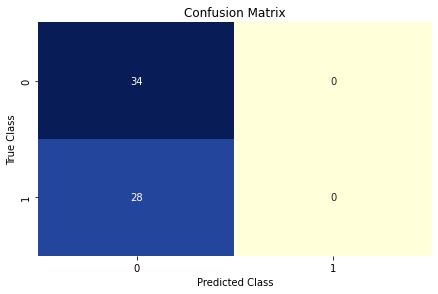

In [ ]:
import seaborn as sns
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

In [ ]:
TP = cf_matrix[0,0] # true positive
TN = cf_matrix[1,1] # true negatives
FP = cf_matrix[1,0] # false positives
FN = cf_matrix[0,1] # false negatives

P=TP+FN
N=TN+FP

In [ ]:
sensitivity = TP/(TP+FN)
specificity = TN/(FP+TN)
ppv = TP/(TP+FP)
npv = TN/(TN+FN)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


In [ ]:
print("sensitivity: ",sensitivity)
print("specificity: ",specificity)
print("ppv: ",ppv)
print("npv: ",npv)

sensitivity:  1.0
specificity:  0.0
ppv:  0.5483870967741935
npv:  nan


In [ ]:
writer.close()

## 학습 결과 나타내기(Tensorboard)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=runs